In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn import metrics
from keras.regularizers import l2
from sklearn.decomposition import PCA
from keras.callbacks import EarlyStopping, ModelCheckpoint

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data manipulation
- classify response variable as the ground truth
- set training and testing set

In [2]:
df = pd.read_csv("Project/Return.csv")
df = df.drop('Date', axis = 1)

df['SPY'] = np.where(df['SPY'] > 0, 1, 0)  # classify SPY as ground truth
df.head()
#df.isnull().sum()

# Split dataset into training and testing set
X = df.values[:, 0:56]
y = df.values[:, 56]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
print('sample size:', df.shape)
print('training size:', X_train.shape)
print('testing size:', X_test.shape)
print(y_train.shape)
print(y_test.shape)

,BAC,MSFT,AAPL,AMZN,FB,BRK.B,GOOG,GOOGL,JNJ,JPM,...,X.VIX,T1,T3,T6,T60,T120,BAA,Inflation,Libor,SPY
0,0.001724,0.023534,0.005374,-0.008490,0.0,-0.011328,0.004313,0.004313,-0.006072,-0.000858,...,-0.032651,0.0,0.0,0.000000,0.000000,0.015228,0.007605,0.030120,0.000000,1
1,0.086059,0.010219,0.011102,0.000563,0.0,0.001693,-0.013871,-0.013871,-0.001222,0.020887,...,-0.033303,0.0,0.0,0.166667,-0.011236,0.010000,-0.001887,0.017544,0.000000,1
2,-0.020602,0.015535,0.010454,0.028152,0.0,-0.007019,-0.013642,-0.013642,-0.008716,-0.008969,...,-0.039572,1.0,0.0,-0.285714,-0.022727,-0.019802,-0.007561,-0.017241,0.003386,0
3,0.014563,-0.013163,-0.001586,-0.022178,0.0,-0.001309,-0.042399,-0.042399,0.001542,-0.001697,...,0.021328,-0.5,-0.5,0.000000,-0.011628,0.000000,0.001905,0.011696,0.000000,1
4,0.057416,0.003605,0.003580,0.004368,0.0,0.014812,0.001092,0.001093,0.004158,0.021246,...,-0.018035,0.0,1.0,0.000000,0.011765,0.010101,-0.001901,-0.017341,-0.001687,1


sample size: (1759, 57)
training size: (1407, 56)
testing size: (352, 56)
(1407,)
(352,)


# Neural network with original data
- Build model and tune parameters
- Set early stop criteria to find the lowest lost

In [3]:
# Build neural network model
lam = 0.01 # regularization parameter
model = Sequential()
model.add(Dense(12, input_dim = 56, kernel_regularizer = l2(lam), activation = 'relu', name = 'L2')) # first hidden layer
model.add(Dense(8, activation = 'relu', kernel_regularizer = l2(lam), name = 'L3')) # second hidden layer
model.add(Dense(1, activation = 'sigmoid', name = 'Output')) # output layer
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

# Use early stopping to find the best model
BEST_MODEL_FILEPATH="best_model"

# Define early stopping based on validation loss
# If three iterations in a row, validation loss is not improved compared with the previous one, stop training
# Mode='min' indicate the loss needs to decrease 
earlyStopping=EarlyStopping(monitor='val_loss', \
                            patience=3, verbose=2, \
                            mode='min')

# Define checkpoint to save best model which has max. validation acc
checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, \
                             monitor='val_acc', \
                             verbose=2, \
                             save_best_only=True, \
                             mode='max')

# Fit model
training = model.fit(X_train, y_train, shuffle = True, 
                     epochs = 1000, batch_size = 36,
                     callbacks=[earlyStopping, checkpoint],
                     validation_data=[X_test, y_test], verbose = 2)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L2 (Dense)                   (None, 12)                684       
_________________________________________________________________
L3 (Dense)                   (None, 8)                 104       
_________________________________________________________________
Output (Dense)               (None, 1)                 9         
Total params: 797
Trainable params: 797
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 1407 samples, validate on 352 samples
Epoch 1/1000
 - 2s - loss: 0.9592 - acc: 0.6233 - val_loss: 0.9108 - val_acc: 0.6392

Epoch 00001: val_acc improved from -inf to 0.63920, saving model to best_model
Epoch 2/1000
 - 0s - loss: 0.8749 - acc: 0.6048 - val_loss: 0.8410 - val_acc


Epoch 00048: val_acc did not improve from 0.87216
Epoch 49/1000
 - 0s - loss: 0.4551 - acc: 0.8806 - val_loss: 0.5030 - val_acc: 0.8523

Epoch 00049: val_acc did not improve from 0.87216
Epoch 00049: early stopping


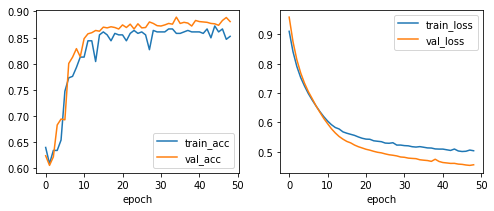

             precision    recall  f1-score   support

          0       0.85      0.86      0.85       166
          1       0.87      0.87      0.87       186

avg / total       0.86      0.86      0.86       352



In [4]:
# Covert the fitting history from dictionary to dataframe
history=pd.DataFrame.from_dict(training.history)
history.columns=["train_loss", "train_acc", \
            "val_loss", "val_acc"]
history.index.name='epoch'
#print(history)

# Plot fitting history
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3));
history[["train_acc", "val_acc"]].plot(ax=axes[0]);
history[["train_loss", "val_loss"]].plot(ax=axes[1]);
plt.show();

# Evaluate prediction
pred = model.predict(X_test)
pred = np.reshape(pred, -1)
pred = np.where(pred > 0.6, 1, 0)
print(metrics.classification_report(y_test, pred, labels = [0, 1]))

# Neural network with PCA
- Check correlation between variables to decide whether necessary to perform dimension reduction
- Find proper number of principal components that contains most information of original data
- Perform neural network again to see the performance of prediction model

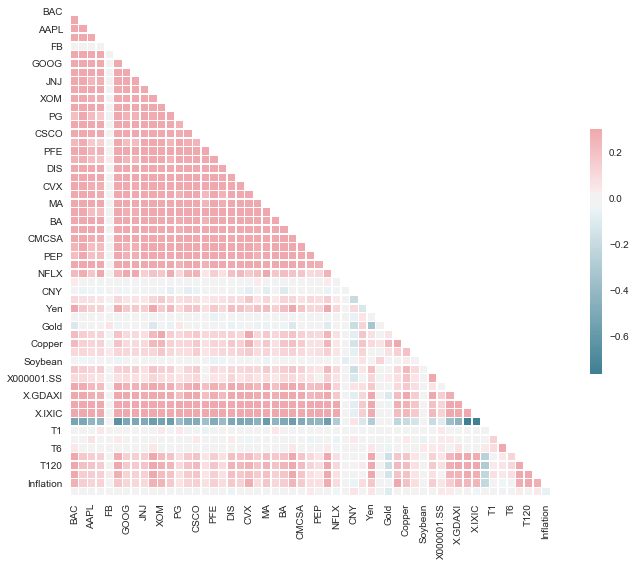

In [5]:
# Investigate predictors' correlation
sns.set(style="white")

# Compute the correlation matrix
corr = df.drop('SPY', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show();

In [6]:
# PCA
df = pd.read_csv("Project/Return.csv")
df = df.drop('Date', axis = 1)
df['SPY'] = np.where(df['SPY'] > 0, 1, 0)
data = df.drop('SPY', axis = 1)

# Try to find the number of principle components which have 99% information of the original dataset
pca = PCA(n_components = 0.99)
pca.fit(data)
print('Variance ratio of each pc:\n', pca.explained_variance_ratio_, '\n')
print('Explained variance of each pc:\n', pca.explained_variance_, '\n')
print('Selected {} pcs'.format(pca.n_components_))

# Select the first 15 principle components according to the previous results
pca = PCA(n_components = 15)
pca.fit(data)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Variance ratio of each pc:
 [0.49164689 0.22310797 0.17399545 0.03139151 0.0269632  0.02574271
 0.00427114 0.00315007 0.00295903 0.00191945 0.00164236 0.00113733
 0.00095714 0.00082209 0.00072999] 

Explained variance of each pc:
 [0.16175179 0.0734025  0.05724449 0.0103278  0.00887089 0.00846935
 0.0014052  0.00103637 0.00097352 0.0006315  0.00054034 0.00037418
 0.0003149  0.00027047 0.00024017] 

Selected 15 pcs


PCA(copy=True, iterated_power='auto', n_components=15, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

[0.49164689 0.22310797 0.17399545 0.03139151 0.0269632  0.02574271
 0.00427114 0.00315007 0.00295903 0.00191945 0.00164236 0.00113733
 0.00095705 0.00082202 0.00072967]
[0.16175179 0.0734025  0.05724449 0.0103278  0.00887089 0.00846935
 0.0014052  0.00103637 0.00097352 0.0006315  0.00054034 0.00037418
 0.00031487 0.00027045 0.00024006]


In [7]:
# Build transformed dataset
dataDecomp = pca.transform(data)
dataDecomp = pd.DataFrame(dataDecomp)
df_pca = pd.concat([dataDecomp, df['SPY']], axis = 1)
df_pca.head()

# Fit in the same NN model with transformed dataset
X_pca = df_pca.values[:, 0:15]
y_pca = df_pca.values[:, 15]
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, y_pca, test_size = 0.2, random_state = 123)
print(X_pca_train.shape, y_pca_train.shape, X_pca_test.shape, y_pca_test.shape)

lam = 0.01
model = Sequential()
model.add(Dense(12, input_dim = 15, kernel_regularizer = l2(lam), activation = 'relu', name = 'L2'))
model.add(Dense(8, activation = 'relu', kernel_regularizer = l2(lam), name = 'L3'))
model.add(Dense(1, activation = 'sigmoid', name = 'Output'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

BEST_MODEL_FILEPATH="best_model"
earlyStopping=EarlyStopping(monitor='val_loss', \
                            patience=3, verbose=2, \
                            mode='min')

checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, \
                             monitor='val_acc', \
                             verbose=2, \
                             save_best_only=True, \
                             mode='max')

training_pca = model.fit(X_pca_train, y_pca_train, shuffle = True, 
                     epochs = 1000, batch_size = 36,
                     callbacks=[earlyStopping, checkpoint],
                     validation_data=[X_pca_test, y_pca_test], verbose = 2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,SPY
0,-0.059085,-0.021787,-0.009414,0.136807,-0.033996,0.021656,0.004176,0.078303,-0.041305,-0.049855,-0.039322,-0.017899,0.012828,-0.029018,-0.005787,1
1,-0.053475,0.000037,-0.008760,0.242341,0.072236,0.151089,-0.003916,-0.023120,-0.008779,0.008663,0.006129,-0.034851,0.041302,0.022729,0.017197,1
2,0.916558,-0.227534,-0.005571,-0.040554,-0.197667,-0.227720,-0.033049,0.057524,-0.030522,-0.055964,-0.022411,-0.004112,-0.011351,0.016240,-0.006365,0
3,-0.634867,-0.423227,-0.050605,-0.065315,0.038888,0.058154,0.011293,0.106817,-0.014168,-0.034592,-0.044338,-0.083989,0.002661,-0.008163,-0.038428,1
4,0.106551,0.953790,0.069299,0.006888,-0.109467,-0.086016,0.027436,-0.015042,0.012560,0.032735,0.014272,-0.029513,-0.004281,0.050885,-0.007317,1


(1407, 15) (1407,) (352, 15) (352,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L2 (Dense)                   (None, 12)                192       
_________________________________________________________________
L3 (Dense)                   (None, 8)                 104       
_________________________________________________________________
Output (Dense)               (None, 1)                 9         
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________
Train on 1407 samples, validate on 352 samples
Epoch 1/1000
 - 0s - loss: 0.9144 - acc: 0.5665 - val_loss: 0.8803 - val_acc: 0.6733

Epoch 00001: val_acc improved from -inf to 0.67330, saving model to best_model
Epoch 2/1000
 - 0s - loss: 0.8606 - acc: 0.6809 - val_loss: 0.8364 - val_acc: 0.6932

Epoch 00002: val_acc improved from 0.67330 to 0.69318, saving model to bes


Epoch 00051: val_acc did not improve from 0.87784
Epoch 52/1000
 - 0s - loss: 0.4537 - acc: 0.8706 - val_loss: 0.4866 - val_acc: 0.8523

Epoch 00052: val_acc did not improve from 0.87784
Epoch 00052: early stopping


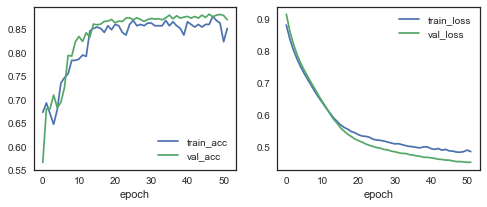

             precision    recall  f1-score   support

          0       0.86      0.86      0.86       166
          1       0.87      0.88      0.87       186

avg / total       0.87      0.87      0.87       352



In [8]:
# Plot fitting history
history_pca=pd.DataFrame.from_dict(training_pca.history)
history_pca.columns=["train_loss", "train_acc", \
                     "val_loss", "val_acc"]
history_pca.index.name='epoch'
#print(history_pca)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3));
history_pca[["train_acc", "val_acc"]].plot(ax=axes[0]);
history_pca[["train_loss", "val_loss"]].plot(ax=axes[1]);
plt.show();

# Evaluate prediction
pred_pca = model.predict(X_pca_test)
pred_pca = np.reshape(pred_pca, -1)
pred_pca = np.where(pred_pca > 0.6, 1, 0)
print(metrics.classification_report(y_pca_test, pred_pca, labels = [0, 1]))

# Univariate time series analysis

In [288]:
import statsmodels.api as sm
from pylab import rcParams
import itertools
from statsmodels.tsa.statespace.varmax import VARMAX

## Data manipulation
- Transform time series data into the proper timestamp form

In [ ]:
# Univariate time series analysis and forcasting
df1 = pd.read_csv("Project/RAW_DATA.csv")
df1['Date'] = pd.to_datetime(df1.Date, format = '%Y-%m-%d')
ts = df1.loc[:, ['Date', 'SPY']]
#ts.isnull().sum()

# Indexing with time series
datetime = []
for date in ts['Date']:
    datetime.append(np.datetime64(date))
ts['Date_time'] = datetime
ts = ts.drop('Date', axis = 1)
ts = ts.set_index('Date_time')
#ts.head()
ts.index

# Use start of each month as the timestamp
y = ts['SPY'].resample('MS').mean()
#y.head()

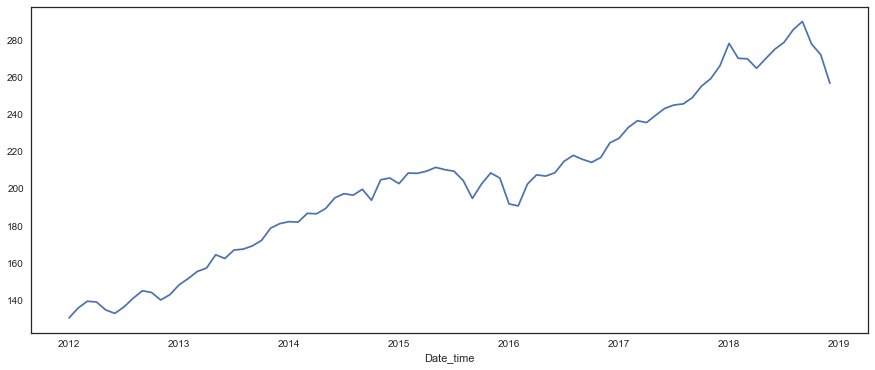

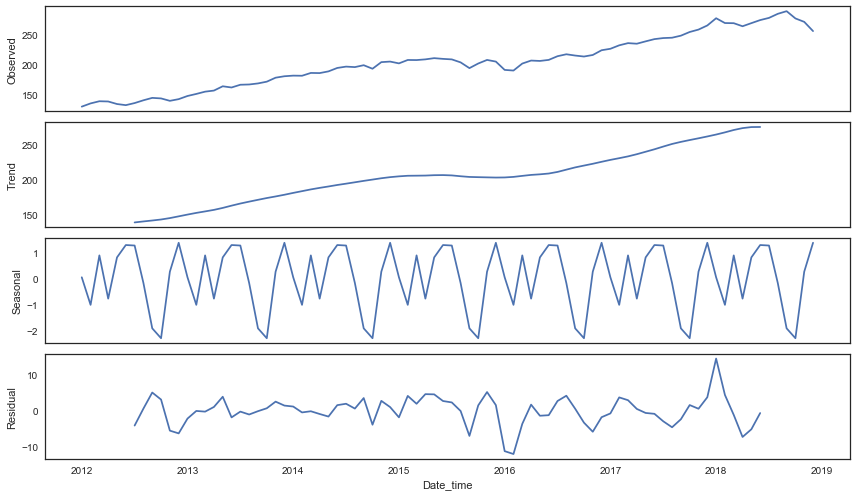

In [286]:
# Visualization
y.plot(figsize = (15, 6))
plt.show();

# Time-series decomposition: trend, seasonality, and noise
rcParams['figure.figsize'] = 12, 7
decomp = sm.tsa.seasonal_decompose(y, model = 'additive')
fig = decomp.plot()
plt.show();

## ARIMA model
- Tune model parameters by grid search
- Fit model and check diagnostics
- Validate prediction with the ground truth

In [202]:
# Forcasting with ARIMA(Autoregressive Integrated Moving Average)
# Grid-search best parameter for seasonality, trend, and noise
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, order = param,\
                                           seasonal_order = param_seasonal,\
                                           enforce_stationarity = False,\
                                           enforce_invertibility = False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

C:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1124.8250977408923
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:906.0946908288029
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:671.9839694248487
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:533.751172204288
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:603.6614819154298
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:577.5617937302063
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:539.0181710654316
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:520.8807680090863
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1005.7740781861587
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:803.5191641059422
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:587.7896420790937
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:473.14163656682405
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:546.8306497941512


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:536.281874426443
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:488.2495300997386
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:464.5705799084157
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:508.07148275672716
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:442.34554636983347
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:477.4267826811307
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:383.30457056712635
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:447.9836848594798
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:444.3435659146345
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:399.9551757178318
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:387.1796500921304
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:499.8917833352419
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:435.4365270190672
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:471.65539401587625
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:376.88725350983003
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:446.44629532449494
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:437.35979065543205
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:400.1040659447694
ARIM

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:445.89590309723945
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:483.8722376807749


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:410.00406056949345
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:444.807473003833
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:446.765306735688
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:400.5188555907112
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:394.0584698802892
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:504.22898842872326


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:440.9980467088738
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:477.68596673162546


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:404.55683917182586
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:445.11179271964016
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:441.7168144493382
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:400.4415806413831
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:387.0700262150339
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:505.25866877729453
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:440.88023918416917
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:477.64349293887244
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:383.0663190100607
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:440.84365946466914
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:442.8307859006225
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:394.1283989749626
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:386.8920655644571
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:501.80255255935054
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:437.32517679901576
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:473.63721490997773
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:378.86448774879005
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:442.8429979308547


C:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2444      0.136      1.798      0.072      -0.022       0.511
ma.S.L12      -1.0000   1.19e+04  -8.38e-05      1.000   -2.34e+04    2.34e+04
sigma2        30.4983   3.64e+05   8.38e-05      1.000   -7.13e+05    7.13e+05


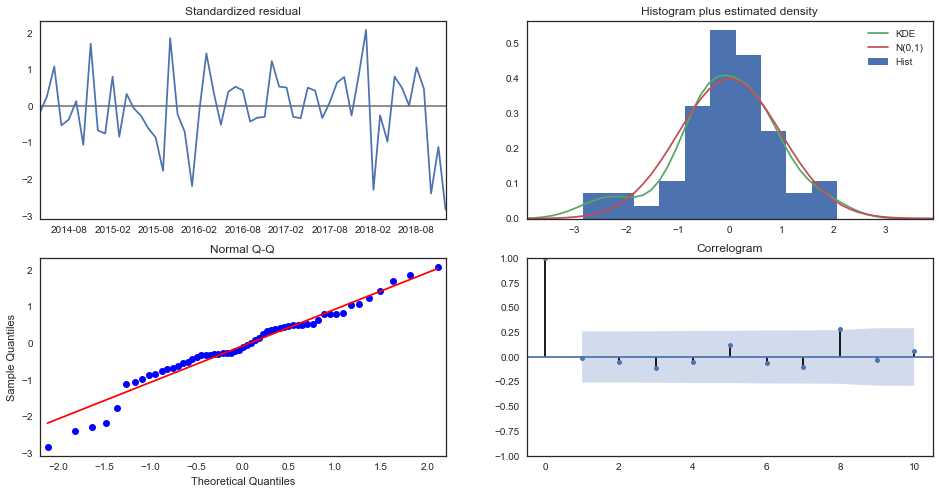

In [203]:
# Fit model using a set of parameters with the lowest AIC
mod = sm.tsa.statespace.SARIMAX(y, order = (0, 1, 1),
                               seasonal_order = (0, 1, 1, 12),
                               enforce_stationarity = False,
                               enforce_invertibility = False)
results = mod.fit()
print(results.summary().tables[1])

# Model diagnostics
results.plot_diagnostics(figsize = (16, 8))
plt.show();

Text(0.5,0,'Date')

Text(0,0.5,'SPY')

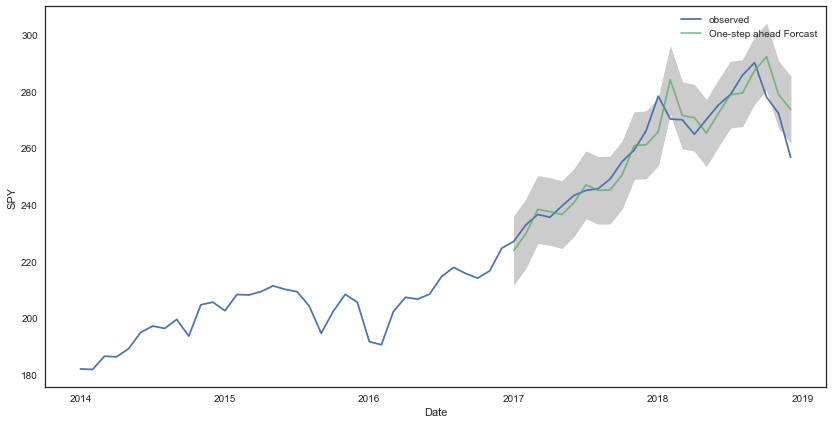

Mean squared error of our forcast is 46.2
Root mean squared error of our forcast is 6.8
SPY range: 127.5 - 293.6


In [291]:
# Validate forecast
pred = results.get_prediction(start = pd.to_datetime('2017-01-01'), dynamic = False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label = 'observed')
pred.predicted_mean.plot(ax = ax, label = 'One-step ahead Forcast', alpha = .7, figsize = (14, 7))
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color = 'k', alpha = .2)
ax.set_xlabel('Date')
ax.set_ylabel('SPY')
plt.legend()
plt.show();

# Numerically evaluate forecast with MSE and RMSE
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

mse = ((y_forecasted - y_truth)**2).mean()
print('Mean squared error of our forcast is {}'.format(round(mse, 2)))
print('Root mean squared error of our forcast is {}'.format(round(np.sqrt(mse), 2)))
print('SPY range: {} - {}'.format(round(min(ts['SPY']), 1), round(max(ts['SPY']), 1)))